([[0.0, 1048.0263102735034, 2094.6606366864403, 3139.0685119142513, 4180.0195247359234, 5215.7604988764269, 6243.8791080427009, 7261.1727031240662, 8263.5432638608509, 9245.9439312714239, 10202.403743475792, 11126.15338785681, 12009.865141213644, 12846.005098103289, 13627.277216805309, 14347.119962255141, 15000.201488746874, 15582.852256170047, 16093.377260914627, 16532.204040330122, 16901.845120933624, 17206.680353849228, 17452.59026024905, 17646.491018835546, 17795.831548226841, 17908.112110277511, 17990.473292535902, 18049.387323854782, 18090.464531881502, 18118.370250755015, 18136.834443802676, 18148.729029245918, 18156.186234772227, 18160.73403828765, 18163.43014108932, 18164.982239236586, 18165.848257435056, 18166.314872377923, 18166.55578375917, 18166.672885300464, 18166.724060063923, 18166.741158053203, 18166.741158053203, 18166.741158053203, 18166.741158053203, 18166.741158053203, 18166.741158053203, 18166.741158053203, 18166.741158053203, 18166.741158053203, 18166.74115805320

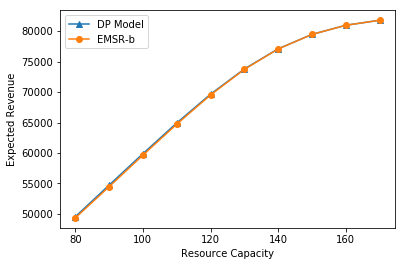

In [1]:
import pandas

import sys
sys.path.append('.')
import RM_exact
import RM_approx
import RM_helper

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

def compare_single_static(products, demands, cap_lb, cap_ub, cap_interval):
    """Compare the exact DP model with a heuristic, EMSR-b, for static models of single-resource RM problems."""
    col_titles = ['DP-rev', 'DP-protect', 'EMSR-b-rev', 'EMSR-b-protect', '%Sum.Opt']
    capacities = [c for c in range(cap_lb, cap_ub + 1, cap_interval)]
    n_products = len(products)
    
    result = []
    for cap in capacities:
        dp_model = RM_exact.Single_RM_static(products, demands, cap)
        dp_result = dp_model.value_func()
        
        approx_model = RM_approx.Single_EMSR(products, demands, cap)
        approx_result = approx_model.value_func()
        
        dp_rev = dp_result[0][n_products - 1][cap]
        approx_rev = approx_result[0][n_products-1][cap]
        
        sub_optimal = (dp_rev - approx_rev) / dp_rev * 100
        result.append([round(dp_rev, 2), dp_result[1],round(approx_rev, 2), approx_result[1], \
                      "{0:.3f}%".format(sub_optimal)])
    
    print(pandas.DataFrame(result, capacities, col_titles))
    return result

# Examples, ref: example 2.3, 2.4 in "The Theory and Practice of Revenue Management"
products = [[1, 1050], [2,567], [3, 534], [4,520]]
# products=[[1, 1050], [2,950], [3, 699], [4,520]]
demands = [(17.3, 5.8), (45.1, 15.0), (39.6, 13.2), (34.0, 11.3)]
lb = 80
ub = 170
result = compare_single_static(products, demands, lb, ub, 10)
x = np.linspace(lb, ub, 10)
y1 = [r[0] for r in result]
y2 = [r[2] for r in result]
# plt.plot(x)
# plt.plot(x,y1, 'g^', x, y2, 'bs')
# plt.ylabel('Expected Revenue')
# plt.xlabel('Resource Capacity')



line1, = plt.plot(x,y1, marker='^', label='DP Model')
line2, = plt.plot(x,y2, marker='o', label='EMSR-b')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=1),line2: HandlerLine2D(numpoints=1)})
# legend = ax.legend(loc='upper center')
plt.ylabel('Expected Revenue')
plt.xlabel('Resource Capacity')
plt.show()






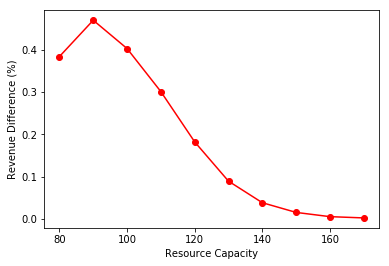

In [11]:

x = np.linspace(lb, ub, 10)
y_diff = [float(r[4].strip('%')) for r in result]
plt.ylabel('Revenue Difference (%)')
plt.xlabel('Resource Capacity')
plt.plot(x, y_diff, 'ro-')

plt.show()

calculating value function using:  [0, 0]
received products, r, d =  [['2ab', 1400], ['1a', 1050], ['2a', 950], ['1ab', 760], ['3b', 722], ['3a', 699], ['4a', 520], ['1b', 501], ['2b', 352]] ['a', 'b'] [['2ab', (24.3, 6.4)], ['1a', (17.3, 5.8)], ['2a', (45.1, 15.0)], ['1ab', (11.5, 2.1)], ['3b', (22.5, 6.1)], ['3a', (39.6, 13.2)], ['4a', (34.0, 11.3)], ['1b', (20, 3.5)], ['2b', (63.1, 2.5)]]
indicies for partition of source  a  is:  [3]
indicies for partition of source  b  is:  [1]
vc= [['2ab,1a,2a', 1096.078], ['1ab,3a,4a', 635.727]] , demand= [(28.9, 17.309), (28.367, 17.503)] , cap= 30
vc= [['2ab', 1400.0], ['1ab,3b,1b,2b', 488.61]] , demand= [(24.3, 6.4), (29.275, 7.754)] , cap= 30
total_exp_rev =  57564.4399252
value func:  ([[[0.0, 1040.7958814002204, 2074.7005105712951, 3101.05393109638, 4119.1605562058876, 5128.2907358360462, 6127.6828206194068, 7116.5457380380567, 8094.062088403608, 9059.3917599606848, 10011.676053379808, 10950.042296375917, 11873.608919353966, 12781.490953056

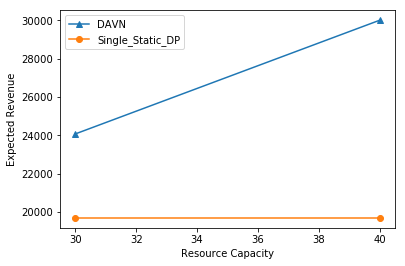

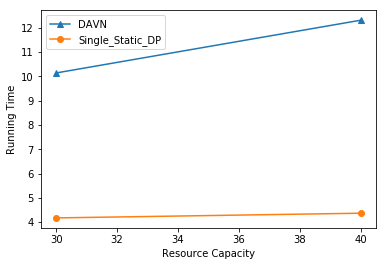

In [7]:

import time
def compare_iDAVN_singleDPstatic(products, resources, n_class, cap_lb, cap_ub, cap_interval):
    """Compare the iterative DAVN method, with a collection of single-resource static DP model."""
    n_resources = len(resources)
    col_titles = ['DAVN:bid-p', 'DAVN:rev', 'DAVN:time']
    capacities = [c for c in range(cap_lb, cap_ub + 1, cap_interval)]
    for i in range(n_resources):
            resource_name = resources[i]
            col_titles.append('S-S: rev-' + resource_name)
    
    col_titles.append("S-S: sum")
    col_titles.append("S-S:total time")
    
    table_data = []
    for cap in capacities:
        result= []
        caps = [cap for c in range(n_resources)]
        (pros, demands, demands_with_names) = RM_helper.sort_product_demands(products)
        DAVN_time = time.time()

        DAVN_bid_prices, DAVN_total_rev = RM_approx.iterative_DAVN(pros, resources, demands_with_names, n_class,\
                                                                   caps, caps)
        DAVN_time = time.time() - DAVN_time

        result.append(DAVN_bid_prices)
        result.append(DAVN_total_rev)
        result.append(DAVN_time)

        single_static_vf = []
        single_total_time =0
        for i in range(n_resources):
            resource_name = resources[i]
            products_i = [j for j in products if resource_name in j[0]]
    #         print("products for resource " + resource_name + " are: ", products_i)
            ps, ds, _ = RM_helper.sort_product_demands(products_i)
            
            single_time = time.time()
            problem = RM_exact.Single_RM_static(ps, ds, capacities[i])
            vf_i = problem.value_func()
            single_time = time.time() - single_time
            single_total_time += single_time
            
            single_static_vf.append(vf_i[0][-1][-1])
    #         print("products: ", ps, ds, ", value =", vf_i)
            result.append(vf_i[0][-1][-1])
        result.append(sum(single_static_vf))
        result.append(single_total_time)
        
        table_data.append(result)
    
    print(pandas.DataFrame(table_data, capacities, col_titles))
    return table_data


# Compare
products = [['1a', (17.3, 5.8), 1050], ['2a', (45.1, 15.0),950], ['3a', (39.6, 13.2), 699], ['4a', (34.0, 11.3),520],\
            ['1b', (20, 3.5), 501], ['2b', (63.1, 2.5), 352], ['3b', (22.5, 6.1), 722], ['1ab', (11.5, 2.1), 760],\
            ['2ab', (24.3, 6.4), 1400]]
resources = ['a', 'b']
# compare_iDAVN_singleDPstatic(products,resources, 6, 80, 120, 10)
lb = 30
ub = 40
data = compare_iDAVN_singleDPstatic(products, resources, 2, lb, ub, 10)

revs_DAVN = [d[1] for d in data]
revs_singleDP = [d[5] for d in data]
time_DAVN = [d[2] for d in data]
time_singleDP = [d[6] for d in data]

x= np.linspace(lb, ub, (ub - lb) / 10 + 1)

line1, = plt.plot(x,revs_DAVN, marker='^', label='DAVN')
line2, = plt.plot(x,revs_singleDP, marker='o', label='Single_Static_DP')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=1),line2: HandlerLine2D(numpoints=1)})
# legend = ax.legend(loc='upper center')
plt.ylabel('Expected Revenue')
plt.xlabel('Resource Capacity')
plt.show()

line3, = plt.plot(x,time_DAVN, marker='^', label='DAVN')
line4, = plt.plot(x,time_singleDP, marker='o', label='Single_Static_DP')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=1),line2: HandlerLine2D(numpoints=1)})
# legend = ax.legend(loc='upper center')
plt.ylabel('Running Time')
plt.xlabel('Resource Capacity')
plt.show()

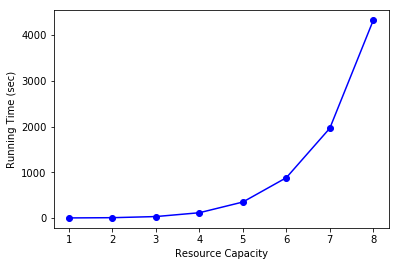

In [4]:
# Draw the graph of running time of the network_DP model
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(1, 8, 8)
y = [0.527467727,5.557183,30.04833006,113.901170,347.9840,879.96475,1961.55373,4324.17709]
# plt.plot(x)
plt.plot(x,y, 'bo-')
plt.ylabel('Running Time (sec)')
plt.xlabel('Resource Capacity')
plt.show()